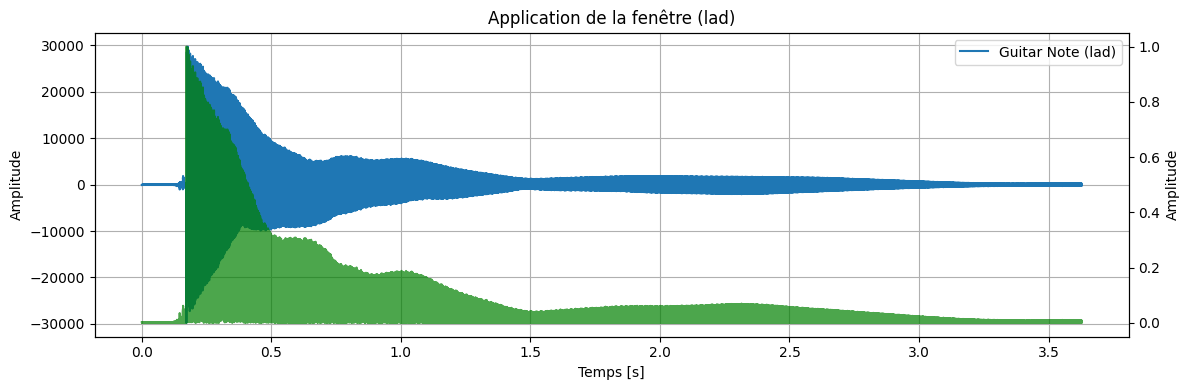

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import wavfile
from scipy.signal import find_peaks

Fe, data = wavfile.read('note_guitare_lad.wav')

if len(data.shape) > 1:
    data = data[:, 0]

time = np.linspace(0, len(data) / Fe, len(data))

fig, ax1 = plt.subplots()
plt.grid(True)


fig.set_size_inches(12,4)

ax1.plot(time, data, label='Guitar Note (lad)')
plt.xlabel('Temps [s]')
ax1.set_ylabel('Amplitude')
ax1.set_title('Application de la fenêtre (lad)')
ax1.legend()

ax2 = ax1.twinx()

redressed_data = abs(data) / max(abs(data))
window = np.hamming(len(redressed_data)) * redressed_data

ax2.plot(time, redressed_data, color="green", alpha=0.7)
# ax2.plot(time, np.hamming(len(redressed_data))/10, color='red')
ax2.set_ylabel('Amplitude')

fig.tight_layout()



884



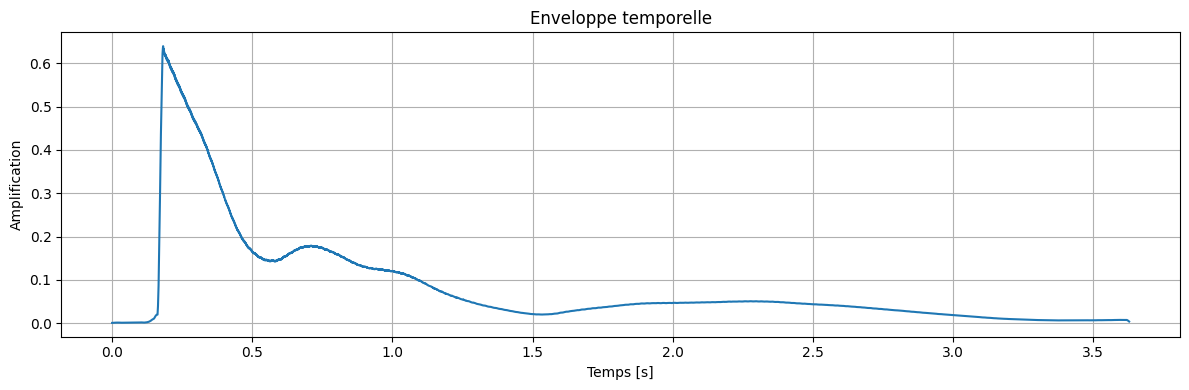

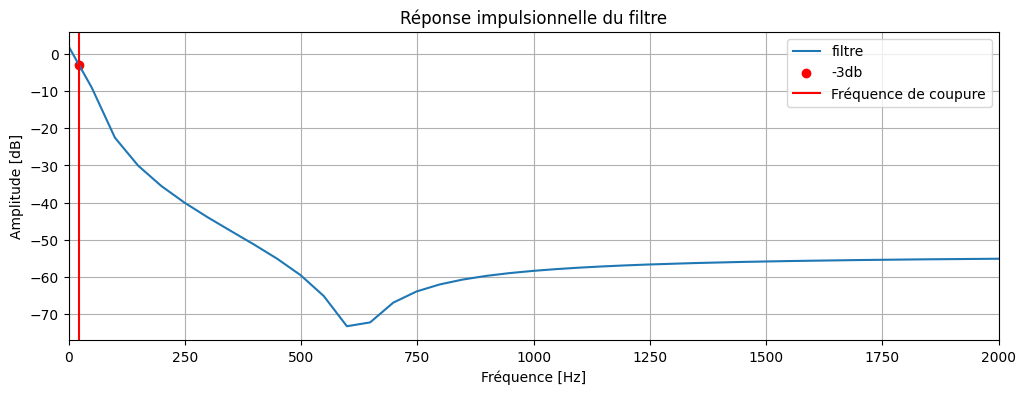

In [ ]:
def ordre(w, gain):
    for N in range(1,1000):
        H = (1/(N+1)) * np.abs(np.sin((N+1)*w/2)/np.sin(w/2))
        if H <= gain:
            return N
    return 0

N = ordre(np.pi / 1000, 10 ** (-3 / 20))
Fc = ((np.pi / 1000) * Fe) / (2*np.pi)
n = np.linspace(-(N - 1) / 2, (N - 1) / 2 + 1, N)

k = (2 * N * Fc / Fe) + 1

h = np.sin(np.pi * n * k / N) / (N * np.sin(np.pi * n / N))
h[0] = k/N

enveloppe = np.convolve(redressed_data, h, mode="same")

ffth = np.fft.rfft(h)
h_amp = np.log10(abs(ffth)) * 20
hfreqs = np.fft.rfftfreq(N, 1/Fe)

plt.figure(figsize=(12, 4))
plt.title('Enveloppe temporelle')
plt.plot(time,enveloppe)
plt.xlabel('Temps [s]')
plt.ylabel('Amplification')
plt.grid(True)
plt.tight_layout()
plt.savefig("./images/enveloppe-guitare.jpg")

plt.figure(figsize=(12, 4))
plt.title("Réponse impulsionnelle du filtre")
plt.plot(hfreqs, h_amp, label="filtre")
plt.scatter(Fc, -3, color="red", label="-3db")
print()
plt.axvline(22.05, color="red", label="Fréquence de coupure")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(0, 2000)
# plt.ylim(-10, 0)
plt.legend()
plt.grid(True)
plt.savefig("./images/reponse-h-guitare.jpg")

plt.show()


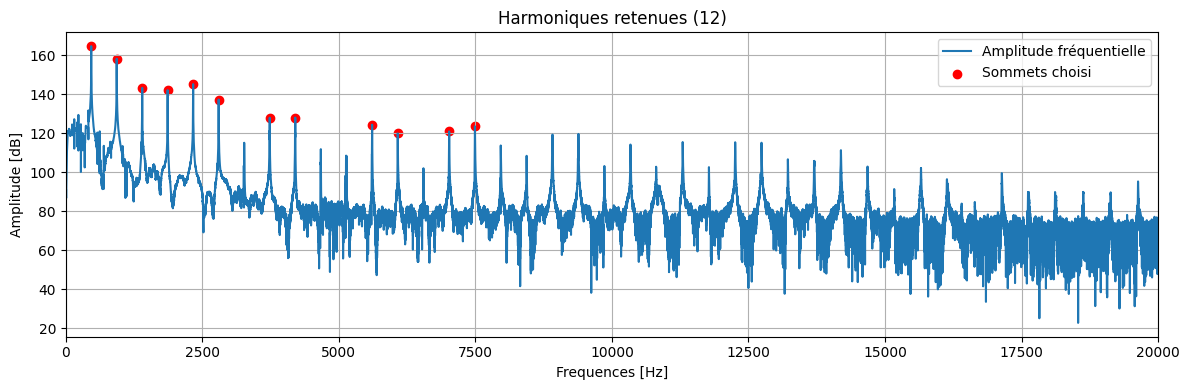

<Figure size 640x480 with 0 Axes>

In [16]:
guitare_fft = np.fft.rfft(data)
guitare_fft_freq = np.fft.rfftfreq(len(data), 1/Fe)

amplitude = abs(guitare_fft)
amplitudelog = np.log10(abs(guitare_fft)) * 20

peaks, _ = find_peaks(
        amplitudelog,
        distance=400,
        prominence=50
    )
peak_amp = amplitude[peaks]
top = peaks[np.argsort(-peak_amp)[:12]]

plt.figure(figsize=(12, 4))
plt.title(f'Harmoniques retenues ({len(top)})')
plt.plot(guitare_fft_freq, amplitudelog, label="Amplitude fréquentielle")
plt.scatter(guitare_fft_freq[top], amplitudelog[top], color='red', label="Sommets choisi")
plt.xlabel('Frequences [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim((0,20000))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("./images/harmoniques-guitare.jpg")

with open(f"{len(top)}_harmoniques.txt", "w") as f:
    f.write("Frequency(Hz), Amplitude, Phase(rad)\n")

    for i in top:
        f.write(
            f"{guitare_fft_freq[i]}, "
            f"{amplitudelog[i]}, "
            f"{np.angle(guitare_fft[i])}\n"
        )

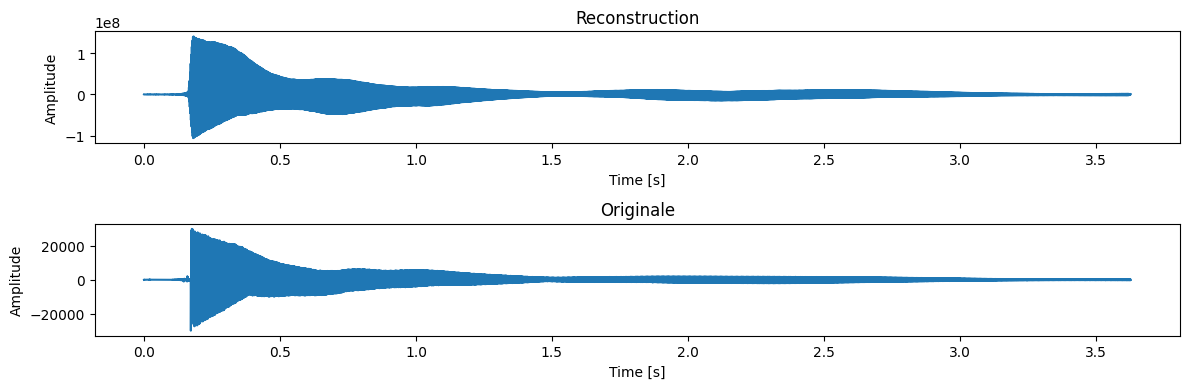

In [17]:
harmoniques_i = top
harmoniques_freq = guitare_fft_freq[harmoniques_i]
harmoniques_amp  = amplitude[harmoniques_i]

def getFacteur(k):
    return 2**(k/12)

def createSignus(k):
    reconstructed = np.zeros_like(data, dtype=np.float64)
    for freq, mag in zip(harmoniques_freq, harmoniques_amp):
        phase = np.angle(guitare_fft[np.where(guitare_fft_freq == freq)[0][0]])
        reconstructed += mag * np.cos(2 * np.pi * getFacteur(k) * freq * time + phase)

    return reconstructed * enveloppe
    
reconstructed = createSignus(0)
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.plot(time, reconstructed)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Reconstruction')
plt.subplot(2,1,2)
plt.plot(time, data, label='Original')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Originale')
plt.tight_layout()
plt.show()

reconstructed_norm = reconstructed / np.max(np.abs(reconstructed)) * 32767
reconstructed_int16 = reconstructed_norm.astype(np.int16)

wavfile.write('out.wav', Fe, reconstructed_int16)

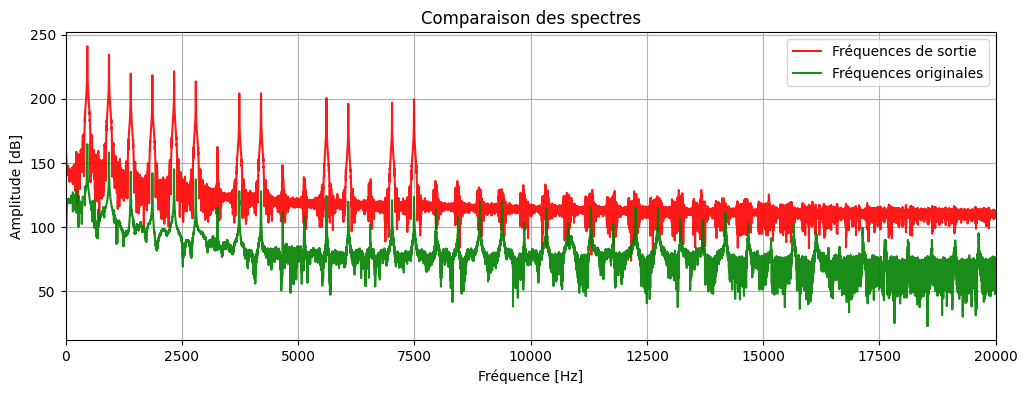

In [18]:
amplituderec = np.abs(np.fft.rfft(reconstructed))

plt.figure(figsize=(12, 4))
plt.title("Comparaison des spectres")
plt.plot(guitare_fft_freq, 20 * np.log10(amplituderec), alpha=0.9, label="Fréquences de sortie", color="red")
plt.plot(guitare_fft_freq, amplitudelog, alpha=0.9, label="Fréquences originales", color="green")
plt.grid(True)
plt.xlim((0,20000))
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend()
plt.savefig("./images/comparaison-spectre-guitare.jpg")
plt.show()

In [19]:


notes = [
    ("DO",   -10),
    ("DO#",   -9),
    ("RÉ",    -8),
    ("RÉ#",   -7),
    ("MI",    -6),
    ("FA",    -5),
    ("FA#",   -4),
    ("SOL",   -3),
    ("SOL#",  -2),
    ("LA",    -1),
    ("LA#",    0),
    ("SI",     1),
]

for note, k in notes:
    reconstructed = createSignus(k)

    reconstructed_norm = reconstructed / np.max(np.abs(reconstructed)) * 32767
    reconstructed_int16 = reconstructed_norm.astype(np.int16)

    wavfile.write(f'notes/{note}.wav', Fe, reconstructed_int16)

In [20]:
note_sounds = {}
for note, _ in notes:
    sr, data = wavfile.read(f'notes/{note}.wav')
    note_sounds[note] = data
fs = sr

def cut(note, duration, fs):
    n = int(duration * fs)
    o = int(0.1 * fs)
    x = note[o:o+n]
    return np.hamming(len(x)) * x

In [21]:
sequence = [
    "SOL", "SOL", "SOL", "RÉ#", "FA", "FA", "FA", "RÉ",
]

short = 0.3
long = 2

durations = [
    short, short, short, long, short, short, short, long, 
]

# Générer la mélodie avec coupe et Hamming
melody = np.concatenate([cut(note_sounds[n], d, fs) for n, d in zip(sequence, durations)])

wavfile.write("beethoven_5.wav", fs, melody.astype(np.int16))

In [22]:
sequence = [
    "RÉ", "MI", "FA#", "SI", "LA",
]

# Durée de chaque note en secondes pour imiter le rythme
durations = [
    0.2, 0.3, 0.4, 0.3, 1
]

# Générer la mélodie avec coupe et Hamming
melody = np.concatenate([cut(note_sounds[n], d, fs) for n, d in zip(sequence, durations)])

# Sauvegarder le résultat
wavfile.write('mcdo.wav', fs, melody.astype(np.int16))